In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import mode
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
import gensim
import re
import gensim.downloader as model_api
from sklearn.model_selection import train_test_split

/Users/Coding/mambaforge/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
hvoe = pd.read_csv('HVOE.csv')
mo = pd.read_csv('Montreal Ouest.csv')
passionimo = pd.read_csv('Passionimo.csv')
monkland = pd.read_csv('Monkland.csv')
csl = pd.read_csv('CSL.csv')
ahc = pd.read_csv('Animal Health Clinic.csv')

In [3]:
df = pd.concat((hvoe, mo, passionimo, monkland, csl, ahc))
df

,Date,Name,Review,Rating
0,3 days ago,TheTabletguy,NaN,5 stars
1,a week ago,Jason Poirier Lavoie,NaN,5 stars
2,a week ago,Carlos Ceja cazares,Best care your family pet will get. The whole ...,5 stars
3,2 weeks ago,mara voltaire,"A very nice, clean place. Employées very polit...",5 stars
4,3 weeks ago,Samme Lem,(Translated by Google) This is the second time...,1 star
...,...,...,...,...
473,7 years ago,Liv L,I have been this clinic 4-5 times and with all...,2 stars
474,7 years ago,chloe rousseau,i had an amazing experience . the vet that hel...,5 stars
475,8 years ago,Stephanie Russell,I took my 8 year old cat to the Animal Health ...,5 stars
476,8 years ago,sandra joan,"i absolutely love this place,u can tell they r...",5 stars


In [4]:
df = df.dropna()
df = df.drop(['Date', 'Name'], axis = 1)

In [5]:
df.Rating = df.Rating.str.replace('5 stars', '5')
df.Rating = df.Rating.str.replace('4 stars', '4')
df.Rating = df.Rating.str.replace('3 stars', '3')
df.Rating = df.Rating.str.replace('2 stars', '2')
df.Rating = df.Rating.str.replace('1 star', '1')
df.Rating = df.Rating.astype(int)
df

,Review,Rating
2,Best care your family pet will get. The whole ...,5
3,"A very nice, clean place. Employées very polit...",5
4,(Translated by Google) This is the second time...,1
5,"Thanks so much, receptionist was very pleasant...",5
6,(Translated by Google) She took the time to ca...,4
...,...,...
472,They ran the extra mile to save my cat who was...,5
473,I have been this clinic 4-5 times and with all...,2
474,i had an amazing experience . the vet that hel...,5
475,I took my 8 year old cat to the Animal Health ...,5


In [6]:
df.Review = df.Review.astype(str)
df.Review = [x.lower() for x in df.Review]

In [7]:
words = df.Review.str.split()
words = pd.DataFrame(words.tolist())

In [8]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.Review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,best,care,your,family,pet,will,get,the,whole,staff,...,None,None,None,None,None,None,None,None,None,None
1,a,very,nice,clean,place,employées,very,polite,and,cordial,...,None,None,None,None,None,None,None,None,None,None
2,translated,by,google,this,is,the,second,time,i,go,...,None,None,None,None,None,None,None,None,None,None
3,thanks,so,much,receptionist,was,very,pleasant,to,speak,with,...,None,None,None,None,None,None,None,None,None,None
4,translated,by,google,she,took,the,time,to,call,me,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,they,ran,the,extra,mile,to,save,my,cat,who,...,None,None,None,None,None,None,None,None,None,None
860,i,have,been,this,clinic,4,5,times,and,with,...,None,None,None,None,None,None,None,None,None,None
861,i,had,an,amazing,experience,the,vet,that,help,me,...,None,None,None,None,None,None,None,None,None,None
862,i,took,my,8,year,old,cat,to,the,animal,...,None,None,None,None,None,None,None,None,None,None


In [9]:
word_vectors = model_api.load("word2vec-google-news-300")

words.columns = words.columns.astype(str)

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
    
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
    
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))
emb

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.195221,1.550331,1.163696,4.137482,-1.558563,0.690166,2.068115,-1.725769,-0.178009,0.778442,...,-2.393341,2.072449,-3.943726,0.362679,-1.241798,0.714775,0.205559,-1.317566,-0.556026,-0.446106
1,-0.377197,1.196045,0.384277,0.519043,-1.483398,-0.396729,0.007446,-0.191650,0.942993,1.003540,...,-1.278809,0.202637,-0.280380,0.656372,-0.490662,0.478668,0.614929,-0.557800,0.877747,0.006958
2,0.140961,1.465162,1.018555,5.309143,-4.150345,0.415260,0.986725,-3.945435,2.367310,2.665974,...,-1.438904,3.138351,-4.304504,1.694464,-2.281054,-1.368187,-0.020170,-0.561493,1.211807,-1.624542
3,0.004898,-0.027161,-0.416473,0.755939,-0.428101,0.681519,0.725220,-0.583984,0.516357,0.382507,...,-0.662598,0.693146,-0.149567,0.239502,-0.452515,0.291077,0.017761,-0.408997,1.283813,-0.120476
4,-0.177551,1.340759,0.922546,1.267822,-0.175934,0.322388,0.149414,-2.115234,0.428101,2.228088,...,-0.130070,1.882797,-2.237000,0.678589,-1.353516,-1.220535,0.989746,-0.667465,0.378723,0.090454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1.480743,2.562151,0.315582,3.300354,-2.172607,0.567993,0.338013,-3.478760,0.551819,1.279297,...,-1.585506,0.899170,-4.185211,-0.549671,-1.018677,0.596241,-1.662674,-0.159132,1.293701,-0.924805
860,-0.360718,2.672485,2.078331,5.760132,-1.041306,0.049683,1.095306,-3.496185,1.759757,2.946411,...,-1.054146,2.103546,-4.184723,1.533325,-0.719841,-0.173779,-3.951599,0.787399,0.134399,-0.424126
861,1.183136,1.229034,0.418457,1.951216,-0.297668,0.603882,1.437469,-4.492279,1.257751,2.189178,...,-3.337948,2.631195,-5.318390,0.312523,-3.286438,0.697575,0.617920,-0.239044,1.157005,-2.114075
862,0.498352,2.022217,1.089249,2.266235,-0.226822,-0.129700,0.616638,-3.147751,1.788849,1.577271,...,-2.175838,1.663300,-4.572968,1.219690,-1.053692,0.616993,-1.154297,-0.288437,0.571861,-1.040710


In [10]:
emb = emb.fillna(0)

In [11]:
X = Normalizer().fit_transform(emb) #Normalizer gives better score
sgdr = SGDRegressor()
sgdr.fit(X, df['Rating'])
df['gensim'] = sgdr.predict(X)
sgdr.score(X, df['Rating']) #not very good

0.2937804388228902

In [12]:
COMPRESSED_SIZE = 200

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [13]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(emb)
    distortions.append(kmeanModel.inertia_)

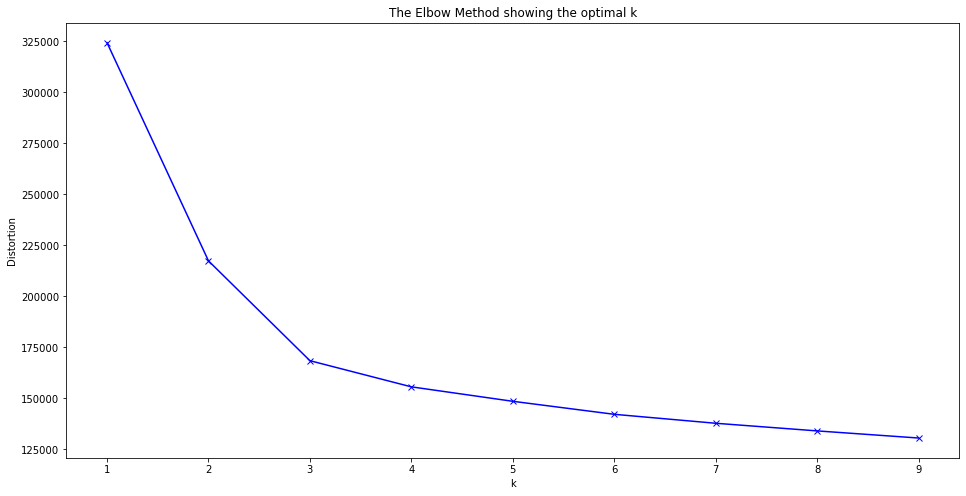

In [14]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() #3 clusters is the way to go

In [15]:
k = 3
model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1)
model.fit(X)
clusters = model.predict(X)

In [16]:
y = np.array(df['Rating'])
labels = np.zeros_like(clusters)
for i in range(5):
    mask = (clusters == i)
    labels[clusters == i] = mode(y[clusters == i])[0]

In [17]:
df['kmeans_tfidf'] = labels
df

,Review,Rating,gensim,kmeans_tfidf
2,best care your family pet will get. the whole ...,5,4.886766,5
3,"a very nice, clean place. employées very polit...",5,4.856813,5
4,(translated by google) this is the second time...,1,3.864302,5
5,"thanks so much, receptionist was very pleasant...",5,4.552723,5
6,(translated by google) she took the time to ca...,4,4.202331,5
...,...,...,...,...
472,they ran the extra mile to save my cat who was...,5,4.237293,5
473,i have been this clinic 4-5 times and with all...,2,3.806641,5
474,i had an amazing experience . the vet that hel...,5,3.984747,5
475,i took my 8 year old cat to the animal health ...,5,4.193697,5


In [18]:
fowlkes_mallows_score(df.kmeans_tfidf, y)

0.7967255338742422

In [19]:
accuracy_score(df.kmeans_tfidf, y) 

0.7881944444444444

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [22]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [23]:
fowlkes_mallows_score(y_pred, y_test) #Best result

0.808890780847353